In [1]:
import pandas as pd 
import numpy as np 
from src.utils.preprocess import get_videoid

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]
DATAPATH = configs["DATAPATH"]
DATAPATH2 = configs["DATAPATH2"]
ROOTPATH2 = configs["ROOTPATH2"]
# OUTPATH = "../../output/results-summary-062624/"
# OUTPATH = "../../output/results-summary-081224/"
# OUTPATH = "../../output/results-summary-111824/"
# OUTPATH = "../../output/results-summary-122724/"
OUTPATH = "../../output/results-summary-052025/"

START = configs["START"]
END = configs["END"]
print(configs)
print(START)
print(END)

{'ROOTPATH': '/Users/yijingch/Documents/GITHUB/invisible-public/', 'ROOTPATH2': '/Users/yijingch/Documents/GITHUB/dd-full/', 'DATAPATH': '/Users/yijingch/Documents/GITHUB/dd-full/data/', 'DATAPATH2': '/Users/yijingch/Documents/GITHUB/collect-youtube-content/data/', 'INDEXPATH': '/Users/yijingch/Documents/GITHUB/dd-full/index/', 'START': datetime.datetime(2018, 5, 1, 0, 0), 'END': datetime.datetime(2023, 5, 1, 0, 0)}
2018-05-01 00:00:00
2023-05-01 00:00:00


## Load data (view, subscribe, comment + survey)

In [2]:
view_all = pd.read_csv(DATAPATH + "youtube/yt_watch.csv", sep=";")
view_all = view_all[["respondent_id","titleUrl","channel_url", "timestamp"]].rename(columns={"titleUrl":"video_url"})
view_all["channel_id"] = view_all["channel_url"].map(lambda x: x.split("/")[-1] if str(x)!= "nan" else np.NaN)
view_all["video_id"] = view_all["video_url"].map(lambda x: get_videoid(x))
view_all = view_all[["respondent_id","channel_id","video_id","timestamp"]]
# view_all = view_all.dropna(subset = ["respondent_id", "video_id", "channel_id"])[["respondent_id","channel_id","video_id","timestamp"]]

subscribe_all = pd.read_csv(DATAPATH + "youtube/yt_subscriptions.csv", sep=";")[["respondent_id","channel_id"]]

comment_all = pd.read_csv(DATAPATH + "youtube/yt_comments_from2018may_to2023may_new.csv", sep=";").rename(columns={"snippet.channelId":"channel_id"})
comment_all = comment_all[["respondent_id","video_id", "channel_id"]] # do not dropna 
comment_public = pd.read_pickle(DATAPATH + "youtube/yt_comments_public_061824.pkl")

view_all["timestamp"] = pd.to_datetime(view_all["timestamp"])
view_all = view_all[(view_all["timestamp"]>=START)&(view_all["timestamp"]<=END)].copy()

comment_public["timestamp"] = pd.to_datetime(comment_public["published_at"]).dt.tz_localize(None)
comment_public = comment_public[(comment_public["timestamp"]>=START)&(comment_public["timestamp"]<=END)].copy()
# subscribing data cannot be filtered; sample comment is already filtered

In [3]:
pol_df = pd.read_csv(DATAPATH + "survey/pol_survey_cleaned_NEW_INCLUDEALL.csv").rename(columns={"user_id":"respondent_id"})
pol_df.head()
print(pol_df.columns)

# get new weights [new!]
pol_df.drop(columns=["weight"], inplace=True)
new_weights = pd.read_spss(DATAPATH + "survey/TK_DataDonation_eng.sav")[["respondent_id","weight"]]
new_weights["respondent_id"] = new_weights["respondent_id"].map(lambda x: int(x))
pol_df = pol_df.merge(new_weights, on="respondent_id", how="left")
len(pol_df)

Index(['respondent_id', 'weight', 'gender', 'birth_year', 'education',
       'fb_freq', 'ig_freq', 'tw_freq', 'yt_freq', 'lk_freq', 'tt_freq',
       'sp_freq', 'sns_view_politics', 'sns_view_politics_friends',
       'sns_view_politics_disagree', 'sns_view_politics_progov',
       'sns_view_politics_antigov', 'seek_politics_tv', 'seek_politics_radio',
       'seek_politics_newpp', 'seek_politics_sites', 'seek_politics_sns',
       'seek_politics_convo', 'talk_politics_frfa', 'align_politics_frfa',
       'interest_politics', 'vote_party_2022', 'would_go_vote_sunday',
       'would_vote_party_sunday', 'know_sppt_fdsz', 'know_sppt_mszp',
       'know_sppt_jbbk', 'know_sppt_lmp', 'know_sppt_dk', 'know_sppt_mtum',
       'know_sppt_mhzk', 'know_relate_fdsz', 'know_relate_mszp',
       'know_relate_jbbk', 'know_relate_lmp', 'know_relate_dk',
       'know_relate_mtum', 'know_relate_mhzk', 'feel_thm_fdsz',
       'feel_thm_mszp', 'feel_thm_jbbk', 'feel_thm_lmp', 'feel_thm_dk',
       'feel_

758

In [4]:
# show interest in politics response distribution
# data = []
# for n in range(5):
#     data.append(len(pol_df[pol_df["interest_politics"]==n]))
# fig,ax = plt.subplots(figsize=(5,3))    
# plt.bar(range(5),data, color="black")
# plt.xlabel("interest in politics", fontsize=12)
# plt.ylabel("# of respondents", fontsize=12)
# plt.show()

## Load labels

In [5]:
# load all political channel 
cols = ["channel_id", "upload_id", "topics_str"]
# channel_info = pd.read_csv(DATAPATH2 + "clean/channel-info.csv")[cols].dropna(subset="topics_str")
channel_info = pd.read_pickle(DATAPATH2 + "clean/channel-info-042624.pkl")[cols].dropna(subset="topics_str")

# get a list of political videos and channels that have uploaded political videos
pol_videos = pd.read_pickle(DATAPATH + "youtube/youtube_video_meta_politics.pkl")["video_id"].tolist()
pol_videos_ch = set(pd.read_pickle(DATAPATH + "youtube/youtube_video_meta_politics.pkl")["channel_id"].tolist())

CHANNEL_CATG = "Politics"
pol_channels = channel_info[channel_info["topics_str"].str.contains(CHANNEL_CATG)]["channel_id"].tolist()
pol_channels = set(pol_channels).union(pol_videos_ch)
print("# of political channels:", len(set(pol_channels)))  # 11346

# of political channels: 11346


In [6]:
channel_labels_hu = pd.read_excel(ROOTPATH2 + "index/yt_polclass_20240627.xlsx")
channel_labels_hu

label_col = "classification_lvl1_4cat"
LABEL_MAP = {
    1: 0, # neutral 
    2: -1, # anti-gov 
    3: 1, # pro-gov
}

channel_labels = channel_labels_hu[channel_labels_hu[label_col].isin(LABEL_MAP.keys())]

CHANNEL_LABEL_MAP = {}
for lab,val in LABEL_MAP.items():
    channel_subdf = channel_labels[channel_labels[label_col]==lab]
    these_channels = set(channel_subdf["channel_id"].tolist())
    print(lab, val, "# of channels", len(these_channels))
    for this_ch in these_channels:
        CHANNEL_LABEL_MAP[this_ch] = val 

CHANNEL_LABEL_MAP["UCKY8HrMpm32WAMK0lauLAZA"] = {"before":-1, "after":1} 

1 0 # of channels 149
2 -1 # of channels 276
3 1 # of channels 139


## Extract user groups

In [7]:
pol_view = view_all[view_all["channel_id"].isin(pol_channels)].copy()
pol_subscribe = subscribe_all[subscribe_all["channel_id"].isin(pol_channels)].copy()
pol_comment = comment_all[comment_all["channel_id"].isin(pol_channels)].copy()
pol_comment_public = comment_public[comment_public["channel_id"].isin(pol_channels)].copy()

In [8]:
# filter for high-interet / low-interest group
these_respondents = set(pol_df[pol_df["interest_politics"].isin([0,1])]["respondent_id"].tolist())

In [9]:
hupol_channels = CHANNEL_LABEL_MAP.keys()
hupol_view = view_all[view_all["channel_id"].isin(hupol_channels)].copy()
hupol_subscribe = subscribe_all[subscribe_all["channel_id"].isin(hupol_channels)].copy()
hupol_comment = comment_all[comment_all["channel_id"].isin(hupol_channels)].copy()
hupol_comment_public = comment_public[comment_public["channel_id"].isin(hupol_channels)].copy()

uall = set(pol_df["respondent_id"].tolist())
uytb = set(view_all["respondent_id"].tolist()).union(set(subscribe_all["respondent_id"].tolist())).union(set(comment_all["respondent_id"].tolist()))
upol = set(pol_view["respondent_id"].tolist()).union(set(pol_subscribe["respondent_id"].tolist())).union(set(pol_comment["respondent_id"].tolist()))
uhup = set(hupol_view["respondent_id"].tolist()).union(set(hupol_subscribe["respondent_id"].tolist())).union(set(hupol_comment["respondent_id"].tolist()))

uv = set(hupol_view["respondent_id"].tolist())
us = set(hupol_subscribe["respondent_id"].tolist())
uc = set(hupol_comment["respondent_id"].tolist())

# # filter for high-interet / low-interest group
# these_respondents = set(pol_df[pol_df["interest_politics"].isin([3,4])]["respondent_id"].tolist())
# uall = set(uall).intersection(these_respondents)
# uytb = set(uytb).intersection(these_respondents)
# upol = set(upol).intersection(these_respondents)
# uhup = set(uhup).intersection(these_respondents)
# uv = set(uv).intersection(these_respondents)
# us = set(us).intersection(these_respondents)
# uc = set(uc).intersection(these_respondents)

# UGROUPS = [uall, uytb, upol, uhup, uv, us, uc]
# UGROUPS_LAB = ["ALL", "YTB", "POL", "POL-HU", "VIEW", "SBSC", "CMNT"]


UGROUPS = [uall, uv, us, uc]
UGROUPS_LAB = ["All", "View", "Subscribe", "Comment"]

In [10]:
from scipy.stats import mstats
tmp = pol_df[["lftRght", "feel_thm_fdsz"]].dropna()
print(mstats.pearsonr(tmp["lftRght"], tmp["feel_thm_fdsz"]))

PearsonRResult(statistic=0.5875231372205358, pvalue=1.6761345282793854e-56)


In [11]:
# from scipy.stats import mstats
# tmp = pol_df[["interest_politics", "feel_thm_fdsz"]].dropna()
# print(mstats.pearsonr(tmp["interest_politics"], tmp["feel_thm_fdsz"]))

# plot_df = pol_df[["interest_politics","feel_thm_fdsz"]].dropna()
# plt.hist2d(plot_df["interest_politics"],plot_df["feel_thm_fdsz"], bins=[5,10])
# plt.show()

In [12]:
# ## before revision

# fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(8,4), sharey=True)
# axes = [x for ls in axes for x in ls]

# varname = "feel_thm_fdsz"
# varname_display = "anti-/pro-government"
# # varname = "lftRght"
# # varname_display = "left/right"
# # varname = "interest_politics"
# # varname_display = "political interest"


# for i,(ax,u,lab) in enumerate(zip(axes, UGROUPS, UGROUPS_LAB)):
#     sub_df = pol_df[pol_df["respondent_id"].isin(u)]
#     if i <= 3: 
#         ax.hist(sub_df[varname], density=True, bins=10, color="grey", weights=sub_df["weight"])
#     else:
#         ax.hist(sub_df[varname], density=True, bins=10, color="black", weights=sub_df["weight"])
#     ax.set_title(lab, fontsize=12)
#     # ax.set_xticks([*range(1,8,2)], [*range(1,8,2)])
#     ax.set_xticks([*range(0,12,2)], [*range(0,12,2)])
#     # ax.set_xticks([*range(0,5,1)], [*range(0,5,1)])
# for i in [0,4]:
#     axes[i].set_ylabel("density", fontsize=12)
# # axes[4].set_xlabel(varname_display, fontsize=12)
# plt.suptitle(varname_display, fontsize=14)
# plt.tight_layout()
# axes[-1].set_visible(False)
# # plt.savefig(OUTPATH + f"distribution-user-{varname}-diff-pol-activities-weighted.pdf", dpi=300, bbox_inches="tight")

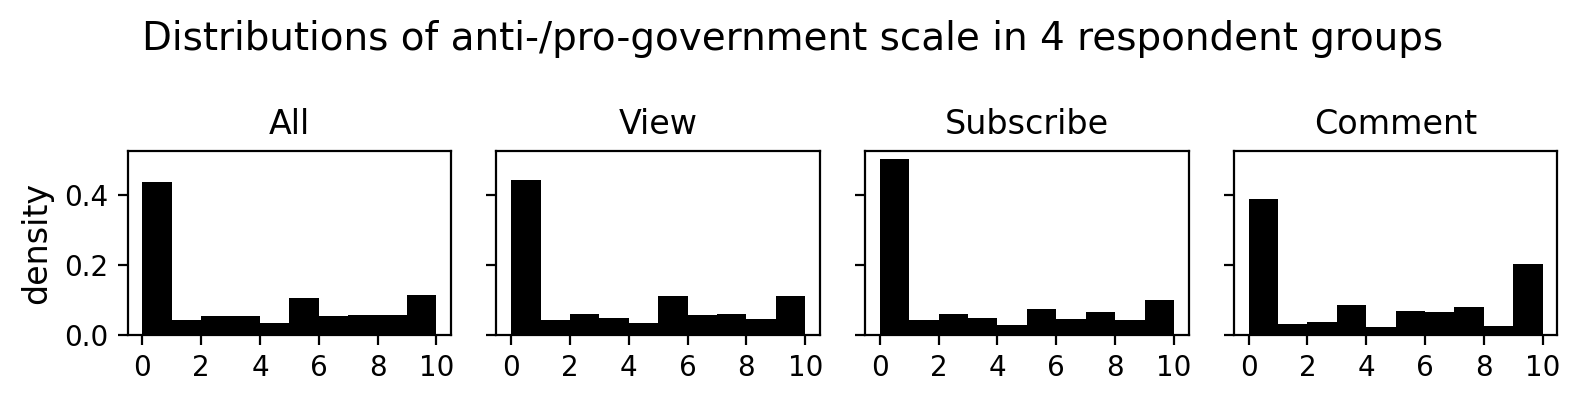

In [13]:
## after revision

fig,axes = plt.subplots(ncols=4, figsize=(8,2), sharey=True)

varname = "feel_thm_fdsz"
varname_display = "Distributions of anti-/pro-government scale in 4 respondent groups"
# varname = "lftRght"
# varname_display = "left/right (interested)"
# varname=""

for i,(ax,u,lab) in enumerate(zip(axes, UGROUPS, UGROUPS_LAB)):
    sub_df = pol_df[pol_df["respondent_id"].isin(u)]
    ax.hist(sub_df[varname], density=True, bins=10, color="black", weights=sub_df["weight"])
    ax.set_title(lab, fontsize=12)
    # ax.set_xticks([*range(1,8,2)], [*range(1,8,2)])
    ax.set_xticks([*range(0,12,2)], [*range(0,12,2)])
axes[0].set_ylabel("density", fontsize=12)
plt.suptitle(varname_display, fontsize=14)
plt.tight_layout()
# plt.savefig(OUTPATH + f"distribution-user-{varname}-diff-pol-activities-weighted-4grp.pdf", dpi=300, bbox_inches="tight")

In [14]:
from scipy.stats import kurtosis

def compute_kurtosis(data):
    data = [d for d in data if str(d) != "nan"]
    if len(data) == 0:
        return np.NaN
    else:
        return kurtosis(data)

def compute_variance(data):
    data = [d for d in data if str(d) != "nan"]
    if len(data) == 0:
        return np.NaN
    else:
        return np.var(data)

In [15]:
# # perform ks test to show the differences are statistically significant 

# from scipy.stats import entropy, ks_2samp, mannwhitneyu

# groups = [
#     ("VIEW", "CMNT"),
#     ("SBSC", "CMNT"), 
#     ("VIEW", "SBSC"),
# ]

# for g1, g2 in groups:
#     # sample1 = bp_data_flth[g1]
#     # sample2 = bp_data_flth[g2]
#     sample1 = bp_data_lrsc[g1]
#     sample2 = bp_data_lrsc[g2]
#     d, p = ks_2samp(sample1, sample2, alternative="less")
#     print(g1, g2, round(d,5), round(p,4))

In [16]:
# # before revision
# nruns = 100
# bp_data_flth_var = {}
# bp_data_lrsc_var = {}
# bp_data_flth_kts = {}
# bp_data_lrsc_kts = {}
# for u,lab in zip(UGROUPS, UGROUPS_LAB):
#     sub_df = pol_df[pol_df["respondent_id"].isin(u)]
#     var_ls_flth = []
#     var_ls_lrsc = []
#     kts_ls_flth = []
#     kts_ls_lrsc = []
#     for r in range(nruns):
#         sub_df_resample = sub_df.sample(n=len(sub_df), replace=True, weights=sub_df["weight"])
#         var_ls_flth.append(compute_variance(sub_df_resample["feel_thm_fdsz"].tolist()))
#         var_ls_lrsc.append(compute_variance(sub_df_resample["lftRght"].tolist()))
#         kts_ls_flth.append(compute_kurtosis(sub_df_resample["feel_thm_fdsz"].tolist()))
#         kts_ls_lrsc.append(compute_kurtosis(sub_df_resample["lftRght"].tolist()))
#     bp_data_flth_var[lab] = var_ls_flth
#     bp_data_lrsc_var[lab] = var_ls_lrsc
#     bp_data_flth_kts[lab] = kts_ls_flth
#     bp_data_lrsc_kts[lab] = kts_ls_lrsc

# fig,axes = plt.subplots(ncols=2, nrows=2, figsize=(10,5))
# for i, (bp_data, title) in enumerate(zip([bp_data_flth_var, bp_data_lrsc_var], ["feel_thm_fdsz", "lftRght"])):
#     bp_data = bp_data.values()
#     bp = axes[0,i].boxplot(bp_data, sym="+")
#     axes[0,i].set_xticks(range(1,len(UGROUPS_LAB)+1), UGROUPS_LAB, fontsize=12)
#     # axes[0,i].set_title(title, fontsize=14)
#     axes[0,0].set_ylabel("variance", fontsize=14)


#     for median in bp["medians"]:
#         median.set_color("black")

# for i, (bp_data, title) in enumerate(zip([bp_data_flth_kts, bp_data_lrsc_kts], ["feel_thm_fdsz", "lftRght"])):
#     bp_data = bp_data.values()
#     # vp = axes[1,i].violinplot(bp_data, showmedians=True, )
#     bp = axes[1,i].boxplot(bp_data, sym="+")
#     axes[1,i].set_xticks(range(1,len(UGROUPS_LAB)+1), UGROUPS_LAB, fontsize=12)
#     # axes[1,i].set_title(title, fontsize=12)
#     axes[1,0].set_ylabel("kurtosis", fontsize=14)


#     for median in bp["medians"]:
#         median.set_color("black")

# axes[0,0].set_title("anti-/pro-government", fontsize=14)
# axes[0,1].set_title("left/right", fontsize=14)
# # axes[0].set_ylim(8.4, 19.4)
# # axes[1].set_ylim(-1.8, 0.5)

# plt.suptitle("Among respondents who are interested in politics", fontsize=15)
# plt.tight_layout()
# # plt.savefig(OUTPATH + "variance_kurtosis_boxplot_interested.png", dpi=300, bbox_inches="tight")

Text(0.5, 1.07, 'Polarization measures for anti-/pro-government scale')

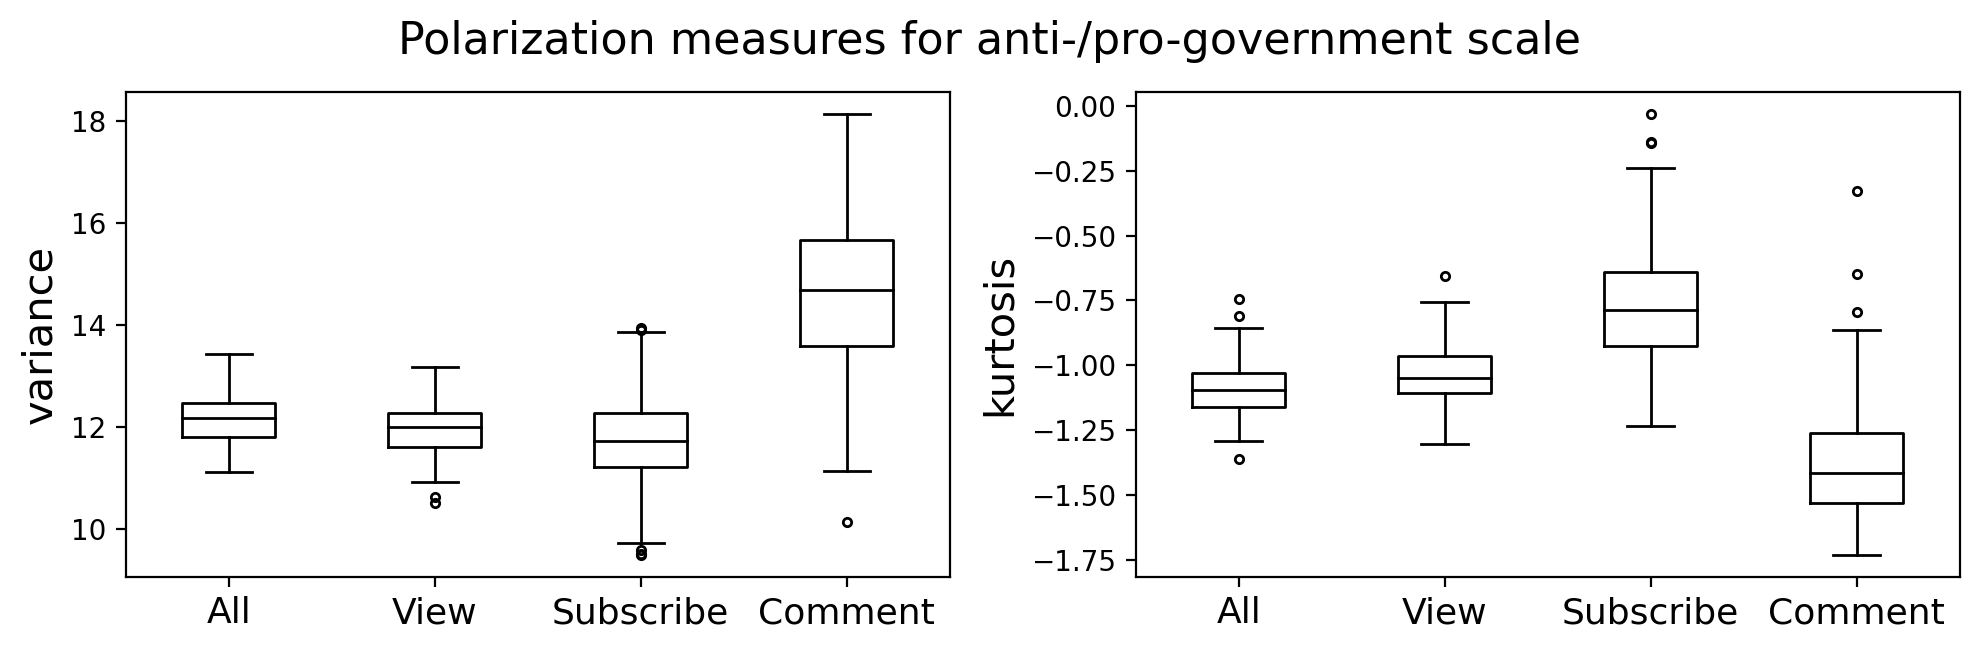

In [17]:
# ## revision r1: separate figures for left/right and anti/pro

# var = "lftRght"
var = "feel_thm_fdsz"
# var = "interest_politics"
nruns = 200
bp_data_var = {}
bp_data_kts = {}
for u,lab in zip(UGROUPS, UGROUPS_LAB):
    sub_df = pol_df[pol_df["respondent_id"].isin(u)]
    var_ls = []
    kts_ls = []
    for r in range(nruns):
        sub_df_resample = sub_df.sample(n=len(sub_df), replace=True, weights=sub_df["weight"])
        var_ls.append(compute_variance(sub_df_resample[var].tolist()))
        kts_ls.append(compute_kurtosis(sub_df_resample[var].tolist()))
    bp_data_var[lab] = var_ls
    bp_data_kts[lab] = kts_ls

fig,axes = plt.subplots(ncols=2, figsize=(10,3))
bp1 = axes[0].boxplot(bp_data_var.values(), sym=".")
axes[0].set_ylabel("variance", fontsize=15)
bp2 = axes[1].boxplot(bp_data_kts.values(), sym=".")
axes[1].set_ylabel("kurtosis", fontsize=15)

for i,bp in enumerate([bp1, bp2]):
    axes[i].set_xticks(range(1,len(UGROUPS_LAB)+1), UGROUPS_LAB, fontsize=13)
    for median in bp["medians"]:
        median.set_color("black")
plt.tight_layout()
plt.suptitle("Polarization measures for anti-/pro-government scale", fontsize=16, y=1.07)
# axes[0].set_title("interest in politics", fontsize=16)
# plt.savefig(OUTPATH + "variance_kurtosis_boxplot_antiPro_4grp.pdf", dpi=300, bbox_inches="tight")

## Compare distributions

In [18]:
# from scipy.stats import mannwhitneyu

# nruns2 = 200
# Us_lrsc_var = {}
# ps_lrsc_var = {}
# Us_lrsc_kts = {}
# ps_lrsc_kts = {}

# Us_flth_var = {}
# ps_flth_var = {}
# Us_flth_kts = {}
# ps_flth_kts = {}

# GROUPS_TO_COMPARE = [
#     # ("ALL", "YTB"),
#     # ("ALL", "POL"),
#     # ("ALL", "POL-HU"),
#     # ("YTB", "POL"),
#     # ("YTB", "POL-HU"),
#     # ("POL", "POL-HU"),
#     # ("VIEW", "SBSC"),
#     # ("VIEW", "CMNT"),
#     # ("SBSC", "CMNT"),
#     # ("All", "View"), 
# ]
# for g1,g2 in GROUPS_TO_COMPARE:
#     for Us in [Us_flth_var, Us_flth_kts, Us_lrsc_var, Us_lrsc_kts]:
#         Us[(g1,g2)] = []
#     for ps in [ps_flth_var, ps_flth_kts, ps_lrsc_var, ps_lrsc_kts]:
#         ps[(g1,g2)] = []

# for r2 in range(nruns2):
#     print(r2)
#     nruns = 100
#     bp_data_flth_var = {}
#     bp_data_lrsc_var = {}
#     bp_data_flth_kts = {}
#     bp_data_lrsc_kts = {}
#     for u,lab in zip(UGROUPS, UGROUPS_LAB):
#         sub_df = pol_df[pol_df["respondent_id"].isin(u)]
#         var_ls_flth = []
#         var_ls_lrsc = []
#         kts_ls_flth = []
#         kts_ls_lrsc = []
#         for r in range(nruns):
#             sub_df_resample = sub_df.sample(n=len(sub_df), replace=True, weights=sub_df["weight"])
#             var_ls_flth.append(compute_variance(sub_df_resample["feel_thm_fdsz"].tolist()))
#             var_ls_lrsc.append(compute_variance(sub_df_resample["lftRght"].tolist()))
#             kts_ls_flth.append(compute_kurtosis(sub_df_resample["feel_thm_fdsz"].tolist()))
#             kts_ls_lrsc.append(compute_kurtosis(sub_df_resample["lftRght"].tolist()))
#         bp_data_flth_var[lab] = var_ls_flth
#         bp_data_lrsc_var[lab] = var_ls_lrsc
#         bp_data_flth_kts[lab] = kts_ls_flth
#         bp_data_lrsc_kts[lab] = kts_ls_lrsc
        
#     for g1,g2 in GROUPS_TO_COMPARE:
#         for data, Us, ps in zip(
#             [bp_data_flth_var, bp_data_flth_kts, bp_data_lrsc_var, bp_data_lrsc_kts],
#             [Us_flth_var, Us_flth_kts, Us_lrsc_var, Us_lrsc_kts],
#             [ps_flth_var, ps_flth_kts, ps_lrsc_var, ps_lrsc_kts]):
            
#             U, p = mannwhitneyu(data[g1], data[g2], method="asymptotic")
#             Us[(g1,g2)].append(U)
#             ps[(g1,g2)].append(p)

In [19]:
# df = pd.DataFrame()
# df["sample1"] = [x[0] for x in GROUPS_TO_COMPARE]
# df["sample2"] = [x[1] for x in GROUPS_TO_COMPARE]

# # Us = Us_flth_kts
# # ps = ps_flth_kts
# # Us = Us_flth_var
# # ps = ps_flth_var


# Us = Us_lrsc_kts
# ps = ps_lrsc_kts
# # Us = Us_lrsc_var
# # ps = ps_lrsc_var


# ciu = []
# cip = []
# for g1,g2 in GROUPS_TO_COMPARE:
#     this_us = Us[(g1,g2)]
#     this_ps = ps[(g1,g2)]
#     bu = round(np.percentile(this_us, q=5),1)
#     uu = round(np.percentile(this_us, q=95),1)
#     bp = round(np.percentile(this_ps, q=5),2)
#     up = round(np.percentile(this_ps, q=95),2)
#     ciu.append(f"[{bu}, {uu}]")
#     cip.append(f"[{bp}, {up}]")
# df["CIU"] = ciu 
# df["CIP"] = cip


In [20]:
# issue_cols = [
#     # "lftRght", "feel_thm_fdsz",
#     "strEnvm", "regBisn", "porEasy", "favImgr", "govInef", 
#     "milStrg","racDisc", "govHelp", "bizProf", "homAcpt"
#     ]

# fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(10,6))
# axes = [x for ls in axes for x in ls]
# # varname = "lftRght"
# for ax,u,lab in zip(axes, UGROUPS, UGROUPS_LAB):
#     subdf = pol_df[pol_df["respondent_id"].isin(u)]
#     ax.imshow(abs(subdf[issue_cols].corr()), vmin=0, vmax=.6, cmap="Greys")
#     ax.set_title(lab, fontsize=12)
#     ax.set_xticks(range(len(issue_cols)), issue_cols, rotation=90)
#     # ax.set_xlabel(varname, fontsize=12)
#     ax.set_yticks(range(len(issue_cols)), issue_cols)
# plt.tight_layout()
# axes[-1].set_visible(False)
# # plt.savefig(OUTPATH + f"distribution-user-issue-corr-pol-activities.pdf", dpi=300, bbox_inches="tight")
# # TODO: maybe implement a weighted version

In [21]:
aggr_func1 = {"channel_id_time": lambda x: list(x)}
aggr_func2 = {"channel_id":lambda x: list(x)}
pol_view["channel_id_time"] = pol_view.apply(lambda x: (x["channel_id"], x["timestamp"]), axis=1)
view_aggr = pol_view.groupby("respondent_id").agg(aggr_func1).reset_index()
subscribe_aggr = pol_subscribe.groupby("respondent_id").agg(aggr_func2).reset_index()
comment_aggr = pol_comment.groupby("respondent_id").agg(aggr_func2).reset_index()

In [22]:
def get_channel_label(channel_id, label_map, before_after=""):
    if before_after == "":
        return label_map[channel_id]
    else:
        return label_map[channel_id][before_after]

def assign_score_engagement(channel_ls, label_map=CHANNEL_LABEL_MAP):
    num = 0
    den = 0
    for c in channel_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                num += get_channel_label(c, label_map=label_map, before_after="after")
            else:
                num += get_channel_label(c, label_map=label_map)
            den += 1
    if den == 0:
        return np.NaN 
    else:
        return num/den

def assign_score_engagement_temporal(channel_time_ls, label_map=CHANNEL_LABEL_MAP):
    num = 0
    den = 0
    for c,time in channel_time_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                if time <= pd.to_datetime("2020-08-01 00:00:00"):
                    num += get_channel_label(c, label_map=label_map, before_after="before")
                else:
                    num += get_channel_label(c, label_map=label_map, before_after="after")
            else:
                num += get_channel_label(c, label_map=label_map)
            den += 1
    if den == 0:
        return np.NaN 
    else:
        return num/den

def compute_stats_temporal(channel_time_ls, label_map=CHANNEL_LABEL_MAP, func=compute_kurtosis):
    ls = []
    for c,time in channel_time_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                if time <= pd.to_datetime("2020-08-01 00:00:00"):
                    ls.append(get_channel_label(c, label_map=label_map, before_after="before"))
                else:
                    ls.append(get_channel_label(c, label_map=label_map, before_after="after"))
            else:
                ls.append(get_channel_label(c, label_map=label_map))

    dsp = func(ls)
    return dsp

def compute_stats(channel_ls, label_map=CHANNEL_LABEL_MAP, func=compute_kurtosis):
    ls = []
    for c in channel_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                ls.append(get_channel_label(c, label_map=label_map, before_after="after"))
            else:
                ls.append(get_channel_label(c, label_map=label_map))
    dsp = func(ls)
    return dsp

In [23]:
view_aggr["view_score"] = view_aggr["channel_id_time"].map(lambda x: assign_score_engagement_temporal(x))
subscribe_aggr["subscribe_score"] = subscribe_aggr["channel_id"].map(lambda x: assign_score_engagement(x))
comment_aggr["comment_score"] = comment_aggr["channel_id"].map(lambda x: assign_score_engagement(x))

print("# of users to compare:")
print("view:", len(view_aggr))
print("subscribe:", len(subscribe_aggr))
print("comment:", len(comment_aggr))

# of users to compare:
view: 665
subscribe: 428
comment: 112


In [24]:
view_aggr["view_var"] = view_aggr["channel_id_time"].map(lambda x: compute_stats_temporal(x, func=compute_variance))
subscribe_aggr["subscribe_var"] = subscribe_aggr["channel_id"].map(lambda x: compute_stats(x, func=compute_variance))
comment_aggr["comment_var"] = comment_aggr["channel_id"].map(lambda x: compute_stats(x, func=compute_variance))

In [25]:
# sample1 = [x for x in view_aggr["view_score"].tolist() if str(x)!="nan"]
# sample2 = [x for x in subscribe_aggr["subscribe_score"].tolist() if str(x)!="nan"]
# sample3 = [x for x in comment_aggr["comment_score"].tolist() if str(x)!="nan"]

sample1 = [x for x in view_aggr["view_var"].tolist() if str(x)!="nan"]
sample2 = [x for x in subscribe_aggr["subscribe_var"].tolist() if str(x)!="nan"]
sample3 = [x for x in comment_aggr["comment_var"].tolist() if str(x)!="nan"]

In [26]:
from scipy.stats import entropy, ks_2samp, mannwhitneyu
from src.utils.functions import compare_distribution_with_sig, get_p, normalize
from src.utils.functions import compare_distribution_with_sig_weighted

sample_dict = {"VIEW": sample1, "SBSC": sample2, "CMNT": sample3}

groups = [("VIEW", "SBSC"), ("VIEW", "CMNT"), ("SBSC", "CMNT")]

for g1, g2 in groups:
    s1 = sample_dict[g1]
    s2 = sample_dict[g2]
    print(g1, "size =", len(s1), g2, "size =", len(s2))
    p1, p2 = compare_distribution_with_sig(
        s1, 
        s2,
        sample_size=min(len(s1),len(s2)),
        test_func=ks_2samp, 
        bruns=1000)
    print("p1 =", round(p1, 5), "p2 =", round(p2, 5))
    

VIEW size = 640 SBSC size = 299
N1 = 299 	N2 = 299
p1 = 0.0 p2 = 0.0
VIEW size = 640 CMNT size = 72
N1 = 72 	N2 = 72
p1 = 0.0 p2 = 0.0
SBSC size = 299 CMNT size = 72
N1 = 72 	N2 = 72
p1 = 0.0 p2 = 0.0


/Users/yijingch/Documents/GITHUB/invisible-public/src/utils/functions.py:54: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  test_bstr2 = test_func(sample2, bstr_sample2)


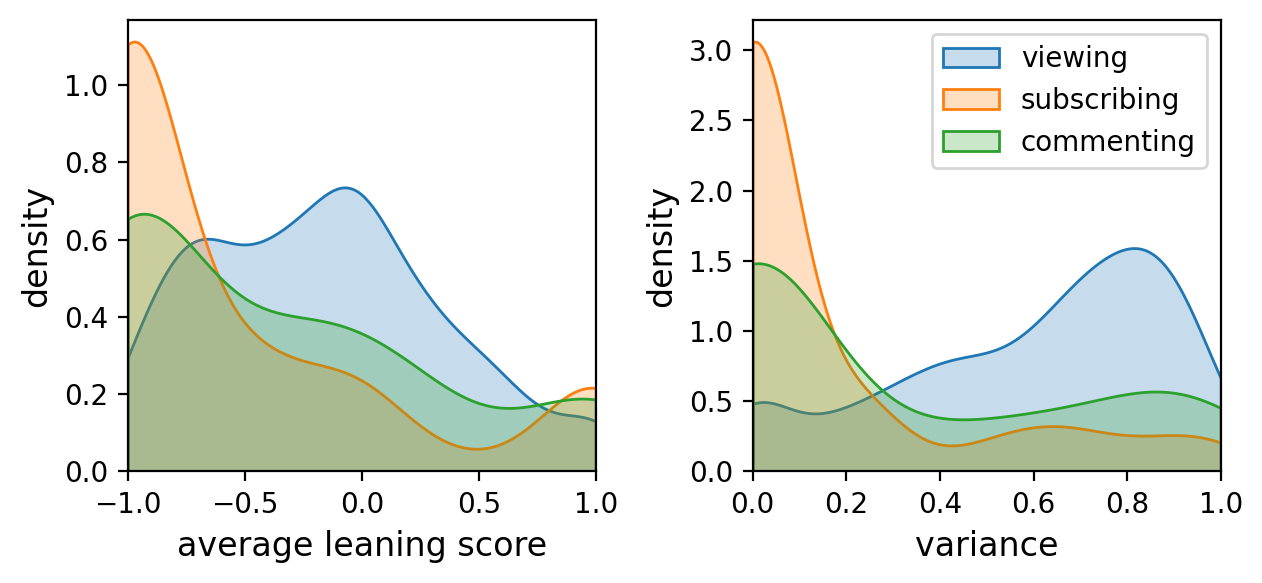

In [27]:
import seaborn as sns
fig,axes = plt.subplots(figsize=(6.4,3), ncols=2)
sns.kdeplot(view_aggr["view_score"], label="viewing", fill=True, ax=axes[0], cut=0)
sns.kdeplot(subscribe_aggr["subscribe_score"], label="subsribing", fill=True, ax=axes[0], cut=0)
sns.kdeplot(comment_aggr["comment_score"], label="commenting", fill=True, ax=axes[0], cut=0)

axes[0].set_xlim(-1, 1)
axes[0].set_xlabel("average leaning score", fontsize=12)
axes[0].set_ylabel("density", fontsize=12)
axes[1].set_ylabel("density", fontsize=12)
# axes[0].legend()

sns.kdeplot(view_aggr["view_var"], label="viewing", fill=True, ax=axes[1], cut=0)
sns.kdeplot(subscribe_aggr["subscribe_var"], label="subscribing", fill=True, ax=axes[1], cut=0)
sns.kdeplot(comment_aggr["comment_var"], label="commenting", fill=True, ax=axes[1], cut=0)
axes[1].set_xlabel("variance", fontsize=12)
axes[1].set_xlim(0, 1)
axes[1].legend()
plt.tight_layout()
# plt.savefig(OUTPATH + "engage-avg-leaning-var.pdf", dpi=300, bbox_inches="tight")

57


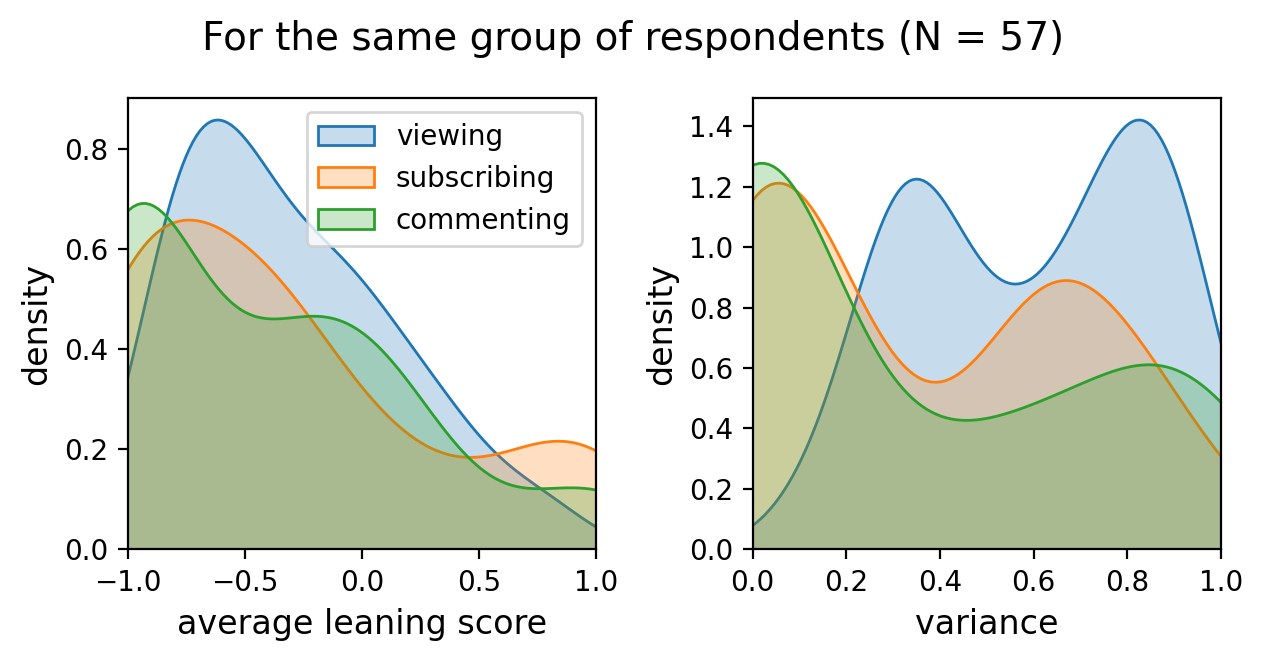

In [29]:
# # if filtering for the same user group
uvsc = uv.intersection(us).intersection(uc)
print(len(uvsc))

import seaborn as sns

fig,axes = plt.subplots(figsize=(6.4,3), ncols=2)
sns.kdeplot(view_aggr[view_aggr["respondent_id"].isin(uvsc)]["view_score"], label="viewing", fill=True, ax=axes[0])
sns.kdeplot(subscribe_aggr[subscribe_aggr["respondent_id"].isin(uvsc)]["subscribe_score"], label="subscribing", fill=True, ax=axes[0])
sns.kdeplot(comment_aggr[comment_aggr["respondent_id"].isin(uvsc)]["comment_score"], label="commenting", fill=True, ax=axes[0])

axes[0].set_xlim(-1, 1)
axes[0].set_xlabel("average leaning score", fontsize=12)
axes[0].set_ylabel("density", fontsize=12)
axes[1].set_ylabel("density", fontsize=12)
# axes[0].legend()

sns.kdeplot(view_aggr[view_aggr["respondent_id"].isin(uvsc)]["view_var"], label="viewing", fill=True, ax=axes[1])
sns.kdeplot(subscribe_aggr[subscribe_aggr["respondent_id"].isin(uvsc)]["subscribe_var"], label="subscribing", fill=True, ax=axes[1])
sns.kdeplot(comment_aggr[comment_aggr["respondent_id"].isin(uvsc)]["comment_var"], label="commenting", fill=True, ax=axes[1])
axes[1].set_xlabel("variance", fontsize=12)
axes[1].set_xlim(0, 1)
axes[0].legend()
plt.tight_layout()
plt.suptitle("For the same group of respondents (N = 57)", fontsize=14, y=1.08)
plt.savefig(OUTPATH + "engage-avg-leaning-var-same-group.pdf", dpi=300, bbox_inches="tight")

In [ ]:
# save the individual-level data and send to Zoli 

# view_aggr.dropna().to_csv(OUTPATH + "view_aggr.csv", index=False)
# subscribe_aggr.dropna().to_csv(OUTPATH + "subscribe_aggr.csv", index=False)
# comment_aggr.dropna().to_csv(OUTPATH + "comment_aggr.csv", index=False)

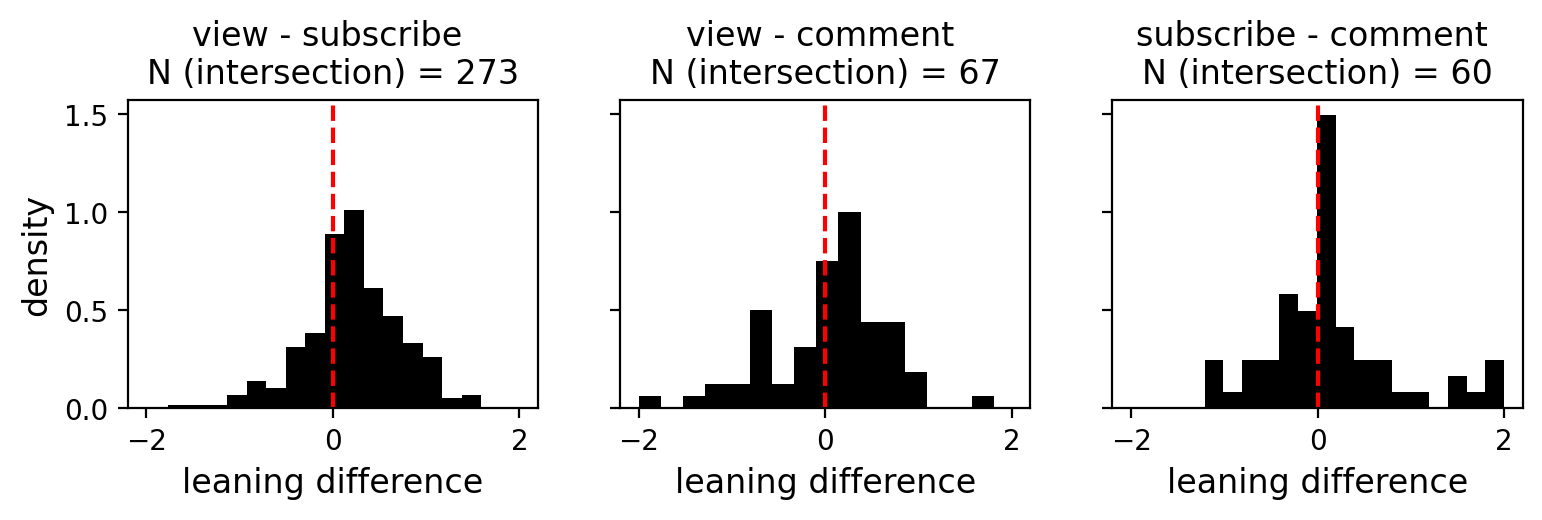

In [31]:
# calculate the leaning difference for individual users

diff_view_subs = view_aggr[["respondent_id","view_score"]].dropna(subset="view_score").merge(
    subscribe_aggr[["respondent_id","subscribe_score"]].dropna(subset="subscribe_score"), on="respondent_id", how="inner")
diff_view_comm = view_aggr[["respondent_id","view_score"]].dropna(subset="view_score").merge(
    comment_aggr[["respondent_id","comment_score"]].dropna(subset="comment_score"), on="respondent_id", how="inner")
diff_subs_comm = subscribe_aggr[["respondent_id","subscribe_score"]].dropna(subset="subscribe_score").merge(
    comment_aggr[["respondent_id","comment_score"]].dropna(subset="comment_score"), on="respondent_id", how="inner")

diff_view_subs["view_subs"] = diff_view_subs["view_score"] - diff_view_subs["subscribe_score"]
diff_view_comm["view_comm"] = diff_view_comm["view_score"] - diff_view_comm["comment_score"]
diff_subs_comm["subs_comm"] = diff_subs_comm["subscribe_score"] - diff_subs_comm["comment_score"]

fig,ax = plt.subplots(figsize=(9,2), ncols=3, sharey=True, sharex=True)
ax[0].hist(diff_view_subs["view_subs"], bins=16, color="black", density=True)
ax[1].hist(diff_view_comm["view_comm"], bins=16, color="black", density=True)
ax[2].hist(diff_subs_comm["subs_comm"], bins=16, color="black", density=True)

ax[0].set_title(f"view - subscribe \nN (intersection) = {len(diff_view_subs)}", fontsize=12)
ax[1].set_title(f"view - comment \nN (intersection) = {len(diff_view_comm)}", fontsize=12)
ax[2].set_title(f"subscribe - comment \nN (intersection) = {len(diff_subs_comm)}", fontsize=12)
ax[0].set_ylabel("density", fontsize=12)

for i in range(3):
    ax[i].axvline(0, color="red", linestyle="--")
    ax[i].set_xlabel("leaning difference", fontsize=12)
plt.show()

In [47]:
diff_view_subs

,respondent_id,view_score,subscribe_score,view_subs
0,20377,-0.250000,-1.000000,0.750000
1,23815,-0.089147,0.000000,-0.089147
2,40479,-0.907104,-1.000000,0.092896
3,41973,-0.902036,-1.000000,0.097964
4,46305,0.177760,0.250000,-0.072240
...,...,...,...,...
268,1265730,0.809249,1.000000,-0.190751
269,1265889,-0.566372,-1.000000,0.433628
270,1266109,-0.689161,-0.428571,-0.260589
271,1266246,-0.846260,-1.000000,0.153740


In [30]:
USER_ANTIPRO_MAP = pol_df[["respondent_id","feel_thm_fdsz"]].set_index("respondent_id").to_dict()["feel_thm_fdsz"]
view_aggr["apgov"] = view_aggr["respondent_id"].map(lambda x: USER_ANTIPRO_MAP[x])
subscribe_aggr["apgov"] = subscribe_aggr["respondent_id"].map(lambda x: USER_ANTIPRO_MAP[x])
comment_aggr["apgov"] = comment_aggr["respondent_id"].map(lambda x: USER_ANTIPRO_MAP[x])
view_aggr["label"] = "view"
subscribe_aggr["label"] = "subscribe"
comment_aggr["label"] = "comment"
cols = ["respondent_id", "apgov", "label"]
all_aggr = pd.concat([
    view_aggr[cols + ["view_score"]].rename(columns={"view_score":"score"}),
    subscribe_aggr[cols + ["subscribe_score"]].rename(columns={"subscribe_score":"score"}),
    comment_aggr[cols + ["comment_score"]].rename(columns={"comment_score":"score"}),
])
all_aggr

,respondent_id,apgov,label,score
0,20145,0.0,view,0.000000
1,20377,6.0,view,-0.250000
2,21712,10.0,view,-0.340426
3,23815,4.0,view,-0.089147
4,26713,0.0,view,-0.476190
...,...,...,...,...
107,1262637,8.0,comment,-1.000000
108,1262676,NaN,comment,-0.733333
109,1265589,8.0,comment,NaN
110,1265730,6.0,comment,-1.000000


0.3435270660011407 4.0292554338075516e-17
0.38754514906007725 2.7476589997971683e-11
0.1779105628472296 0.14359503436015747


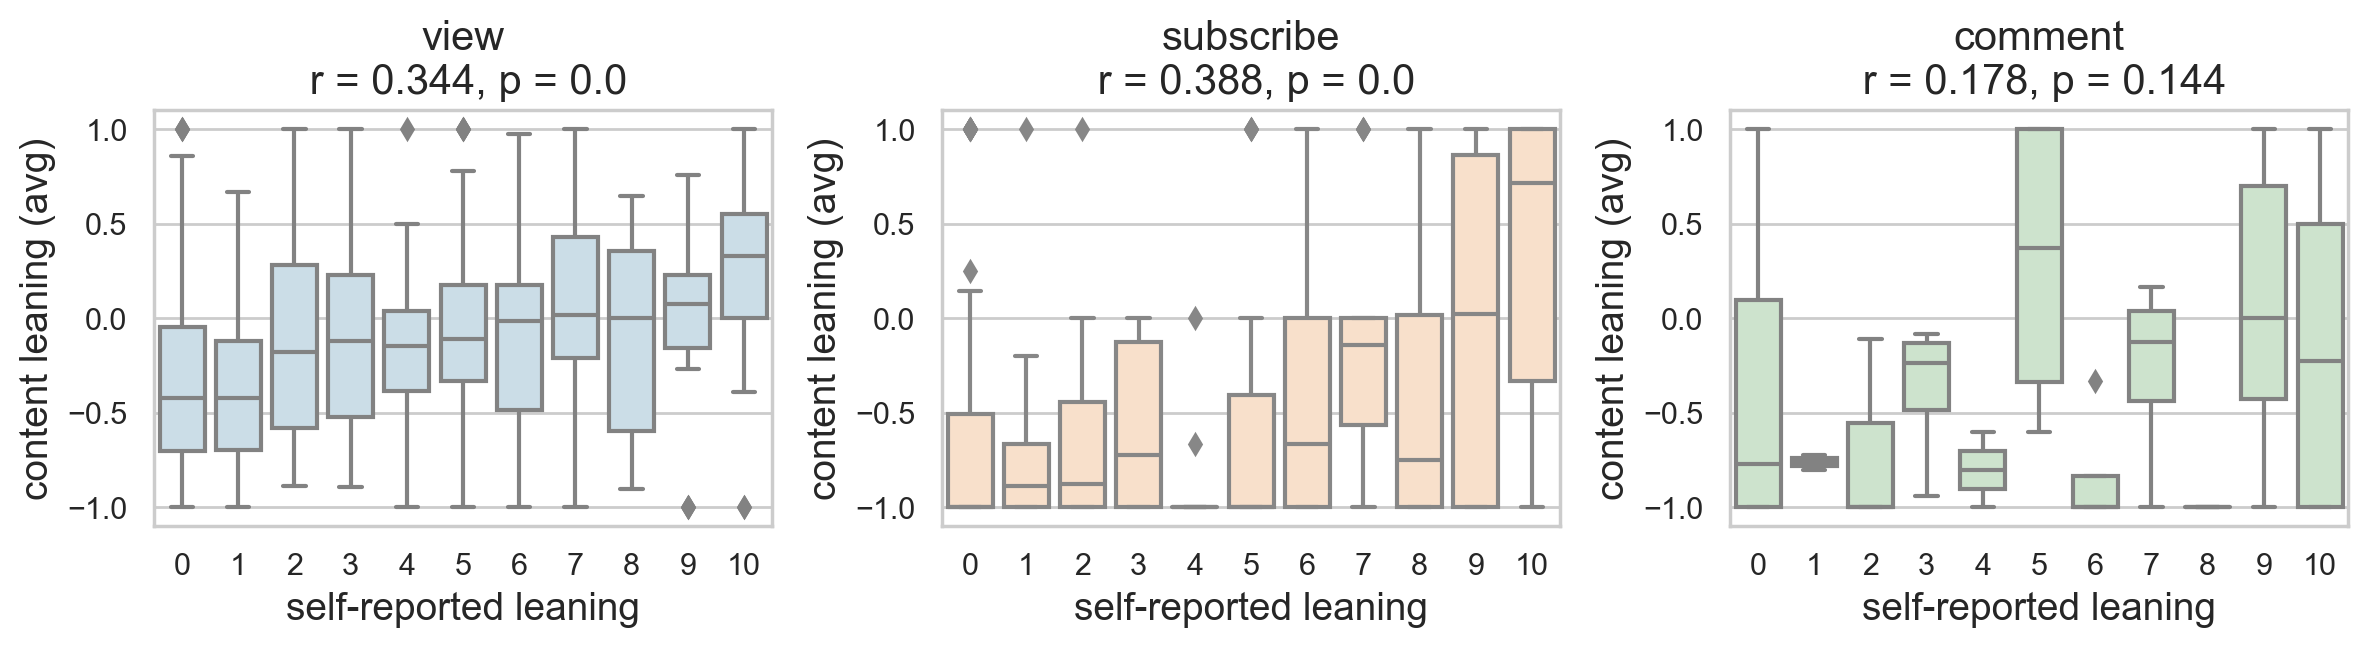

In [33]:
from scipy.stats import mstats
fig,axes = plt.subplots(figsize=(12,3.4), ncols=3)
colors = ["#C6DEEC", "#FFDFC3", "#CAE7C9"]
labels = ["view", "subscribe", "comment"]
sns.set(style="whitegrid")
for i, (ax,lab) in enumerate(zip(axes, labels)):
    sub_aggr = all_aggr[all_aggr["label"]==lab].dropna()
    r,p = mstats.pearsonr(sub_aggr["score"], sub_aggr["apgov"])
    print(r,p)
    # sns.violinplot(x="apgov", y="score", data = sub_aggr, color=colors[i], ax=ax)
    sns.boxplot(x="apgov", y="score", data = sub_aggr, color=colors[i], ax=ax)
    ax.set_ylabel("content leaning (avg)", fontsize=14)
    ax.set_xlabel("self-reported leaning", fontsize=14)
    ax.set_title(lab + f"\n r = {round(r,3)}, p = {round(p,3)}", fontsize=15)
    # ax.set_ylim(-1,1)
    ax.set_xticks(range(0,11), range(0,11))

plt.tight_layout()
# plt.savefig(OUTPATH + "corr_leaning_content_survey.png", dpi=300)

In [34]:
view_bp_data = []
subscribe_bp_data = []
comment_bp_data = []
for i in range(1,11):
    view_bp_data.append([x for x in view_aggr[view_aggr["apgov"]==i]["view_score"].tolist() if str(x)!="nan"])
    subscribe_bp_data.append([x for x in subscribe_aggr[subscribe_aggr["apgov"]==i]["subscribe_score"].tolist() if str(x)!="nan"])
    comment_bp_data.append([x for x in comment_aggr[comment_aggr["apgov"]==i]["comment_score"].tolist() if str(x)!="nan"])

In [ ]:
# checking histogram visualization
# import seaborn as sns
# fig,axes = plt.subplots(figsize=(6.4,3), ncols=2)
# # sns.kdeplot(view_aggr["view_score"], label="viewing", fill=True, ax=axes[0])
# # sns.kdeplot(subscribe_aggr["subscribe_score"], label="subsribing", fill=True, ax=axes[0])
# # sns.kdeplot(comment_aggr["comment_score"], label="commenting", fill=True, ax=axes[0])

# axes[0].hist(view_aggr["view_score"], label="viewing", bins=20)
# axes[0].hist(subscribe_aggr["subscribe_score"], label="subscribing", bins=20)
# axes[0].hist(comment_aggr["comment_score"], label="commenting", bins=20)

# axes[0].set_xlim(-1, 1)
# axes[0].set_xlabel("average leaning score", fontsize=12)
# axes[0].set_ylabel("density", fontsize=12)
# # axes[0].legend()

# axes[1].hist(view_aggr["view_var"], label="viewing", bins=20)
# axes[1].hist(subscribe_aggr["subscribe_var"], label="subscribing", bins=20)
# axes[1].hist(comment_aggr["comment_var"], label="commenting", bins=20)
# axes[1].set_xlabel("variance", fontsize=12)
# axes[1].legend()
# plt.tight_layout()
# # plt.savefig(OUTPATH + "engage-avg-leaning-var.pdf", dpi=300, bbox_inches="tight")